In [1]:
import pandas as pd
import pickle
import torch
import numpy as np
from torch_geometric.data import Data, Dataset

Below we implement a GNN meant for graph-level predicitons. The model performs a regressive task as it trys to predict the average scoring for different questions or groups of questions in the annotations questionare. The GNN employs a shallow message passing architecture to account for the inter connected nature of conversation and is enriched through the use of GATs (Graph Attention Networks) to incorporate edge features in classification. 

Ultimatley, the we can either choose a question or a category (task, social, or general cohesion) and accompany our choice by an agreeability parameter (standard deviation for questions or kappa score for categories) such that we restrict our training/testing group to averages (labels) that present a more robust ground truth. 


The function below takes in: 
- graph_data list: contains node and edge information for all meeting snippets and associates them with a meeting name and start time. 
- df: contains score averages for each question and associates them with meeting and start times. 

Result: the function finds all meeting snippets that occurr in both the df and graph data and only keeps those which abide by the standard deviation parameter. The result is used to build the model dataset. 

In [2]:
def filter_and_associate_data_question_basis(graph_data, df, question, max_std_dev=1.0):

    filtered_df = df[df[f'{question}_std'] <= max_std_dev]
    filtered_graph_data = []

    # find corresponding row in the filtered DataFrame
    for graph_entry in graph_data:
        meeting = graph_entry['meeting']
        start = graph_entry['start']

        # Find the matching row
        match = filtered_df[(filtered_df['Meeting'] == meeting) & (filtered_df['Start'] * 60 == start)]
        if not match.empty:
            average_score = match[f'{question}_mean'].values[0]
            graph_entry['score'] = average_score
            filtered_graph_data.append(graph_entry)

    return filtered_graph_data


The function below takes in: 
- graph_data list: contains node and edge information for all meeting snippets and associates them with a meeting name and start time. 
- df: contains score averages for each category and associates them with meeting and start times. 

Result: the function finds all meeting snippets that occurr in both the df and graph data and only keeps those which abide by the kappa parameter. The result is used to build the model dataset. 

In [3]:

def filter_and_associate_data_category_basis(graph_data, df_kappa, category, min_kappa=0.2):

    kappa_column = f'{category}_Kappa'
    average_column = f'{category}_Average'

    # Filter based on the minimum Kappa score
    filtered_df = df_kappa[df_kappa[kappa_column] >= min_kappa]
    filtered_graph_data = []

    for graph_entry in graph_data:
        meeting = graph_entry['meeting']
        start = graph_entry['start']

        match = filtered_df[(filtered_df['Meeting'] == meeting) & (filtered_df['Start'] * 60 == start)]
        
        if not match.empty:
            average_score = match[average_column].values[0]
            
            graph_entry['score'] = average_score
            filtered_graph_data.append(graph_entry)

    return filtered_graph_data


Below we have the dataset used, which simply takes in the filtered data and defies required methods. 

In [4]:
class CohesionGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CohesionGraphDataset, self).__init__()
        self.data_list = []

        for entry in data_list:
            # Process node features
            node_features_dict = entry['features'][0]
            node_names = list(node_features_dict.keys())  
            node_features = []

            # convert features to a tensor
            for node in node_names:
                node_data = node_features_dict[node]
                node_features.append([feature[1] for feature in node_data])  

            x = torch.tensor(node_features, dtype=torch.float)

            # Process edges
            edge_features_dict = entry['features'][1]
            edge_index = []
            edge_attr = []

            # Convert into tensors
            for edge, edge_data in edge_features_dict.items():
                src, dst = edge.split(',')
                src_idx = node_names.index(src)  # Get the node index for source
                dst_idx = node_names.index(dst)  # Get the node index for destination

                # Append the edge index 
                edge_index.append([src_idx, dst_idx])

                # Append the edge attributes (features for this edge)
                edge_attr.append([feature[1] for feature in edge_data])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  
            edge_attr = torch.tensor(edge_attr, dtype=torch.float) 

            # Store the score as the y label
            y = torch.tensor([entry['score']], dtype=torch.float)

            # Create Geometric Data object
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            self.data_list.append(data)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


Below we have the GNN model. The following features stand out: 

1. Single Convolutional Layer: Convolutional Layers in GNNs are used to derive node embeddings based on a node's surroudning neighbors. The greater the number of layers, the more a node's embeddings are defined by nodes which lie further away. The size and edge density of a graoh should be considered when defining the number of layers, as too many layers for a small and densely connected graph can lead to oversmoothing, a situation where node embedings are homogenous. Given we have a small, fully interconnected graph, we chose a single layer. 

2. Drop Out Layer: Given our sample sizes are rather small, drop out layers are implemented to avoid overfitting

3. GATConv: This mechanism incorporates edge features. I have not taken the time to understand its innerworking, but feel free to: 
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html

4. Global Mean Pooling: Makes this a graoh-level implementation. Chosen rather arbitrarily. 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

NUM_EDGE_FEATURES = 3
NUM_NODE_FEATURES = 12

class CohesionGNN(torch.nn.Module):
    def __init__(self, num_features= NUM_NODE_FEATURES, hidden_size=32, target_size=1, dropout=0.5):
        super(CohesionGNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.dropout = dropout

        self.conv1 = GATConv(self.num_features, self.hidden_size, edge_dim=NUM_EDGE_FEATURES)
        
        self.linear = nn.Linear(self.hidden_size, self.target_size)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Apply GAT convolution layer
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Global mean pooling: aggregates node embeddings 
        x = global_mean_pool(x, batch)  
        
        # Apply final linear layer for regression
        x = self.linear(x)  
        
        return x 


Sinple function to make sure no nan values are present, as they break the model. 

In [6]:
def filter_out_nan_entries(dataset):
    filtered_data_list = []
    
    for data in dataset:
        if (torch.isnan(data.x).any() or
            torch.isnan(data.edge_attr).any() or
            torch.isnan(data.y).any()):
            continue
        else:
            filtered_data_list.append(data)

    return filtered_data_list

Lets now load in the graph data as well as the two data frames we will be using to build datasets. 

In [7]:
import pickle
import pandas as pd 

# Load the graphs data from file
with open('/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/GNNs/data/annotations_graphs_new.pkl', 'rb') as f:
    graphs_cohesion_data = pickle.load(f)

# Load question-level scores df 
question_level_df = pd.read_pickle("/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/Question_Split_data.pkl")
category_level_df = pd.read_pickle("/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/Cohesion_Annotations/Cohesion_split_data.pkl")

load an example of each a questiion-level and category-level filtered data list. 

In [8]:
filtered_data_question = filter_and_associate_data_question_basis(graphs_cohesion_data, question_level_df, 'M3', 1.2)
filtered_data_cat = filter_and_associate_data_category_basis(graphs_cohesion_data, category_level_df, 'Cohesion', 0.2)


Lets now build the dataset

Size of training/validation set: 65
Size of testing set: 16


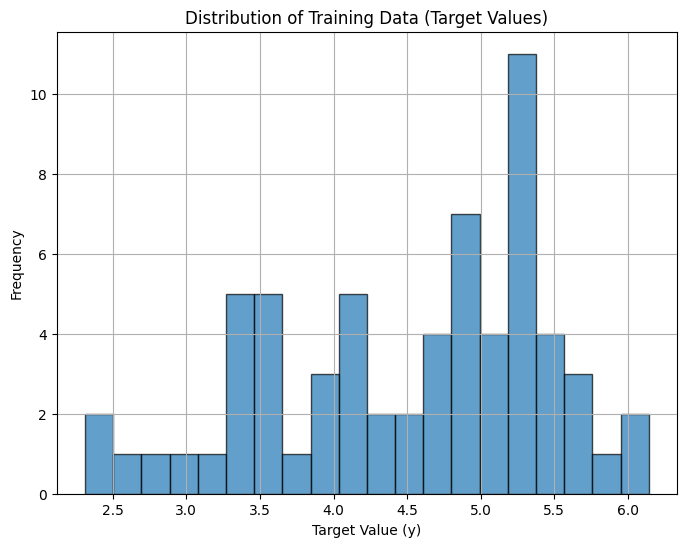

In [9]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt

# create dataset and split using stratified sampling
dataset = CohesionGraphDataset(filtered_data_cat)

# Assuming `dataset` is your full dataset (a list of Data objects)
total_size = len(dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_val_size = total_size - test_size  # 80% for training and validation

# Create a random split for training_val and test sets
data_train_val, data_test = random_split(dataset, [train_val_size, test_size])

# filter out NaN entries in your dataset
data_train_val = filter_out_nan_entries(data_train_val)
data_test = filter_out_nan_entries(data_test)

print(f'Size of training/validation set: {len(data_train_val)}')
print(f'Size of testing set: {len(data_test)}')

# get labels 
train_val_targets = [data.y.item() for data in data_train_val]

# plot distribution
# Plot the distribution of the training data (y values)
plt.figure(figsize=(8, 6))
plt.hist(train_val_targets, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Training Data (Target Values)')
plt.xlabel('Target Value (y)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

To acount for dataset biases, which predomninantly tend towards high cohesion scores, we will employ the DenseWeight library to obtain weights for each observation which can then be utilized in the loss function to apply a greater penalty to gradients which favor high cohesion predictions. 

In [10]:
from denseweight import DenseWeight

# # Lets add a weight to each observation in the training data 
# dw = DenseWeight(alpha=0.5)
# train_val_weights = dw.fit(train_val_targets)

# for i, data in enumerate(data_train_val):
#     data.weight = torch.tensor([train_val_weights[i]], dtype=torch.float)


/Users/manuelnunezmartinez/Documents/UF/Research Internship/code/transcriptionEnv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [37]:
def calculate_bin_statistics(weights, targets, num_bins=4):
    """
    Calculate the product N_i * N_w for each bin and return the standard deviation.
    """
    
    # Adjust the bin edges to ensure a more even distribution
    bin_edges = np.linspace(min(targets), max(targets), num_bins + 1)
    # Use np.digitize to assign each target to a bin
    bin_indices = np.digitize(targets, bin_edges, right=True)
    
    # Merge the first two bins together
    bin_indices[bin_indices == 0] = 1
    
    bin_stats = []
    for i in range(0, num_bins + 1):
        bin_mask = bin_indices == i
        N_i = np.sum(bin_mask)  # Number of observations in the bin
        N_w = np.sum(weights[bin_mask])  # Sum of weights in the bin
        
        if N_i > 0 and N_w > 0:
            bin_stats.append(N_i * N_w)

    # Return the standard deviation of Ni * Nw across bins
    return np.std(bin_stats) if bin_stats else float('inf')


def find_optimal_alpha(train_val_targets, data_train_val, alpha_range=(0, 2), num_bins=4):
    """
    Perform a search over the range of alpha values and minimize the standard deviation of Ni * Nw across bins.
    """
    alphas = np.linspace(alpha_range[0], alpha_range[1], 50)  
    best_alpha = None
    best_std = float('inf')

    alpha_vs_std = []
    
    for alpha in alphas:
        # Fit the DenseWeight model with the current alpha
        dw = DenseWeight(alpha=alpha)
        train_val_weights = dw.fit(train_val_targets)
        
        # Assign the weights to each data point
        for i, data in enumerate(data_train_val):
            data.weight = torch.tensor([train_val_weights[i]], dtype=torch.float)
        
        # Calculate the standard deviation of Ni * Nw across bins
        std_deviation = calculate_bin_statistics(train_val_weights, train_val_targets, num_bins=num_bins)
        alpha_vs_std.append((alpha, std_deviation))

        if std_deviation < best_std:
            best_std = std_deviation
            best_alpha = alpha

    # Extract the alpha values and standard deviations for plotting
    alphas, std_devs = zip(*alpha_vs_std)
    
    # Plot alpha vs standard deviation
    plt.figure(figsize=(8, 5))
    plt.plot(alphas, std_devs, marker='o', linestyle='-', color='b', label='Std Dev of Ni * Nw')
    plt.xlabel('Alpha')
    plt.ylabel('Standard Deviation of Ni * Nw')
    plt.title('Alpha vs Standard Deviation of Ni * Nw')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Best alpha: {best_alpha} with minimum std of Ni * Nw: {best_std}")
    return best_alpha

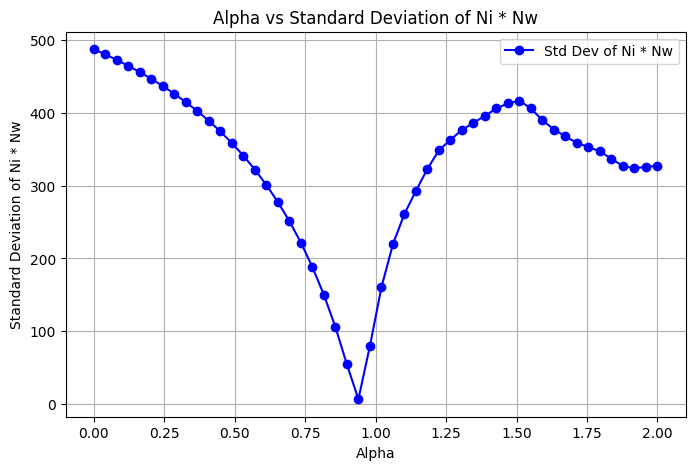

Best alpha: 0.9387755102040816 with minimum std of Ni * Nw: 6.514555939793809


In [42]:
alpha = find_optimal_alpha(train_val_targets, data_train_val,  num_bins=2)

We now move onto model training

Below we have the hyperparameters used. I've opted for a small batch size given I have a small dataset and I am betting on a a greater number of small subgroups to best train the model, given the data size limit. I have found that 0.01 is generally the best learning rate. 

In [87]:
hyperparams = {
    'batch_size' : 4, 
    'save_loss_interval' : 10, 
    'print_interval' : 50,
    'n_epochs' : 250, 
    'learning_rate' : 0.005
}

The following evaluation function is used during training to implement early stopping and during testing as well. The function calcluates loss on a data loader using mean squared error given the task is regressivec(however, other loss metrics could be used). 

In [25]:
import torch.nn.functional as F


def evaluate_model(model, data_loader, device):
    model.eval()  
    total_loss = 0
    with torch.no_grad():  
        for data in data_loader:
            data = data.to(device)
            out = model(data)
            
            loss = F.mse_loss(out.squeeze(-1), data.y)  
            total_loss += loss.item() * data.num_graphs  
    return total_loss / len(data_loader.dataset)  

In [26]:
def weighted_mse_loss(pred, target, weight):
    loss = weight * (pred - target) ** 2
    return torch.mean(loss)

Below we train the model using k-fold cross validation. This method is leveraged to compensate for the small training data size. By training k models we randomize the data enough times to better gaugue its generalizability. Additionally, the MSE loss function used is teaked to incorporate weights that accound for sample distribution bias. 

In [71]:
from sklearn.model_selection import KFold
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader  
from torch.utils.data import Subset

def k_fold_train_model(dataset, k_folds=5, hyperparams=None, patience=50, device='cpu'):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_train_losses = []
    fold_val_losses = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"FOLD {fold+1}/{k_folds}")
        print("==========================================")

        # we randomly define training and validation subsets for each training process 
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # These data loaders are used to train and evaaluate 
        train_loader = DataLoader(train_subset, batch_size=hyperparams['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=hyperparams['batch_size'], shuffle=False)
        
        # Initialize model
        model = CohesionGNN(num_features=12, hidden_size=32, target_size=1, dropout=0.5)
        model = model.to(device)
        
        # We use an Adam to perform gradient descent and optimize model weights 
        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False
        train_losses = []
        val_losses = []

        # Train
        for epoch in range(hyperparams['n_epochs']):
            if early_stop:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

            model.train()
            running_loss = 0
            # calculate loss across training batches 
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                # use customized loss function
                loss = weighted_mse_loss(out, data.y, data.weight)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * data.num_graphs  # Multiply loss by batch size

            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)
            
            # Evaluate on validation 
            val_loss = evaluate_model(model, val_loader, device)
            val_losses.append(val_loss)

            # Early stop after 50 epochs of declining validation loss 
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), f'models/best_model_fold_{fold+1}.pth') 
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                early_stop = True

            # Print progress
            if epoch % hyperparams['print_interval'] == 0 or early_stop == True:
                print(f"Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Store losses for this fold
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        print(f"Fold {fold+1} completed.")
        print("==========================================")
    
    # average the losses across all folds
    avg_train_loss = [sum(folds) / len(folds) for folds in zip(*fold_train_losses)]
    avg_val_loss = [sum(folds) / len(folds) for folds in zip(*fold_val_losses)]
    
    return avg_train_loss, avg_val_loss



Below we train the model

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kmodel = CohesionGNN(num_features=12, hidden_size=32, target_size=1, dropout=0.5)
avg_train_loss, avg_val_loss = k_fold_train_model(data_train_val, 
                                                k_folds=5, 
                                                hyperparams=hyperparams, 
                                                patience=50, 
                                                device=device)

# print(f'Average Train Loss: {avg_train_loss} \n Average Validation Loss: {avg_val_loss}')

FOLD 1/5
Epoch: 0 | Train Loss: 15.7666 | Val Loss: 16.4629
Epoch: 50 | Train Loss: 2.0918 | Val Loss: 1.8381
Epoch: 100 | Train Loss: 1.6553 | Val Loss: 2.3229
Epoch: 150 | Train Loss: 1.8249 | Val Loss: 1.7340
Epoch: 200 | Train Loss: 1.7190 | Val Loss: 1.3197
Epoch: 227 | Train Loss: 1.4646 | Val Loss: 0.8265
Early stopping triggered after 228 epochs.
Fold 1 completed.
FOLD 2/5
Epoch: 0 | Train Loss: 18.8114 | Val Loss: 16.5496
Epoch: 50 | Train Loss: 1.8980 | Val Loss: 1.3381
Epoch: 100 | Train Loss: 1.7984 | Val Loss: 1.1607
Epoch: 110 | Train Loss: 1.7550 | Val Loss: 1.2053
Early stopping triggered after 111 epochs.
Fold 2 completed.
FOLD 3/5
Epoch: 0 | Train Loss: 17.5742 | Val Loss: 9.5504
Epoch: 50 | Train Loss: 1.4353 | Val Loss: 2.9110
Epoch: 100 | Train Loss: 1.4337 | Val Loss: 1.3289
Epoch: 109 | Train Loss: 1.5458 | Val Loss: 1.3508
Early stopping triggered after 110 epochs.
Fold 3 completed.
FOLD 4/5
Epoch: 0 | Train Loss: 21.5992 | Val Loss: 19.0337
Epoch: 50 | Train Lo

We now ouput the performance fo each of the k models saved

In [98]:
for i in range(5):
    kmodel.load_state_dict(torch.load(f'models/best_model_fold_{i+1}.pth'))

    kmodel.eval()  
    kmodel = kmodel.to(device)

    # Prepare test data loader
    test_loader = DataLoader(data_test, batch_size=hyperparams['batch_size'], shuffle=False)
    test_loss = evaluate_model(kmodel, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Test Loss for model {i + 1}: {test_loss:.4f}")

Test Loss for model 1: 0.4428
Test Loss for model 2: 0.4297
Test Loss for model 3: 0.6311
Test Loss for model 4: 0.5200
Test Loss for model 5: 0.5168


In [99]:
kmodel.load_state_dict(torch.load(f'models/best_model_fold_2.pth'))

<All keys matched successfully>

In [100]:
from sklearn.metrics import mean_squared_error, r2_score

kmodel.eval()  
kmodel = kmodel.to(device)

# Prepare test data loader
test_loader = DataLoader(data_test, batch_size=hyperparams['batch_size'], shuffle=False)

# List to store predictions and actual values
predictions = []
actuals = []

# Disable gradient 
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = kmodel(data)  
        predictions.append(out.squeeze(-1).cpu().numpy())  
        actuals.append(data.y.cpu().numpy())  

# Flatten predictions and actual values lists
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R-squared: {r2:.4f}")


Test Mean Squared Error: 0.4297
Test R-squared: 0.4524


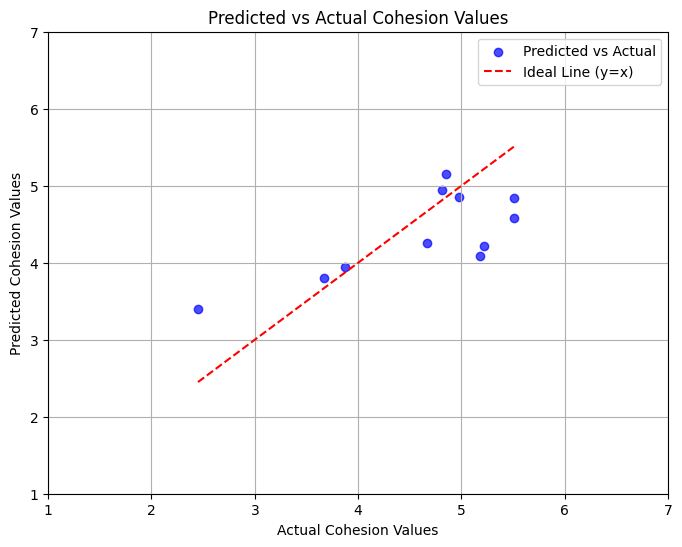

In [101]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.7, color='b', label="Predicted vs Actual")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='r', linestyle='--', label="Ideal Line (y=x)")
plt.xlabel("Actual Cohesion Values")
plt.ylabel("Predicted Cohesion Values")
plt.title("Predicted vs Actual Cohesion Values")
plt.ylim([1,7])
plt.xlim([1,7])
plt.legend()
plt.grid(True)
plt.show()

The results are somewhat promising. The GNN's seem to be capturing general trends, but I don't believe that the data is plentiful enough to expect accurate regressions. Aside from suffering from its small size, the data is somewhat inclined towards high cohesion classifications. 